In [1]:
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import scanpy as sc

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100

from datetime import date
today = str(date.today())

import matplotlib
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 150, vector_friendly = True, format = 'pdf')

data_folder='/nfs/team205/vk8/processed_data/muscle/data_v3/'

In [25]:
def calcul_plot_prop_box2(adata_input, ctype_anno, sample_anno="SampleID", donor_anno="DonorID",
                          age_group="Age_bin", filt_samples=True, subset_rm=[], subset_sel=[], pairs=[],
                          plot_save='', save_dir='',  fig_x = 4, fig_y = 4, **kwargs):
    if filt_samples == True:
        samples = adata_input.obs['SampleID'].value_counts().index[adata_input.obs['SampleID'].value_counts() > 1000]
        adata_obs = adata_input.obs.loc[adata_input.obs['SampleID'].isin(samples), :].copy()
    else:
        adata_obs = adata_input.obs.copy()

    if len(subset_rm) > 0:
        adata_obs = adata_obs.loc[~adata_obs[ctype_anno].isin(subset_rm)].copy()

    adata_obs[ctype_anno].cat.remove_unused_categories(inplace=True)
    sample2pop = adata_obs.groupby([sample_anno, ctype_anno]).count()[['n_counts']] / \
                 adata_obs.groupby([sample_anno]).count()[['n_counts']]
    sample2pop.reset_index(inplace=True)
    if len(subset_sel) > 0:
        sample2pop = sample2pop.loc[sample2pop[ctype_anno].isin(subset_sel)].copy()
        sample2pop[ctype_anno].cat.remove_unused_categories(inplace=True)
        sample2pop[ctype_anno] = sample2pop[ctype_anno].cat.reorder_categories(subset_sel).copy()
    age2donor2sample = adata_obs[[age_group, donor_anno, sample_anno]][
        ~adata_obs[[age_group, donor_anno, sample_anno]].duplicated()]
    age2d2s2ctype = age2donor2sample.merge(sample2pop, how="left", left_on=sample_anno, right_on=sample_anno)
    d2ctype = age2d2s2ctype.groupby([donor_anno, ctype_anno]).mean()['n_counts'].reset_index()
    age2donor = age2d2s2ctype[[age_group, donor_anno]][
        ~age2d2s2ctype[[age_group, donor_anno]].duplicated()].reset_index(drop=True)
    age2d2ctype = age2donor.merge(d2ctype, how="left", left_on=donor_anno, right_on=donor_anno)
    with matplotlib.rc_context({'axes.facecolor': 'black'}):
        rcParams['pdf.fonttype'] = 42
        rcParams['figure.figsize'] = [fig_x, fig_y]
        import seaborn as sns
        sns.set_style(style="ticks")
        sns.set_context("paper")
        # sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
        # sns.set_style("ticks")
        # Draw a nested barplot by species and sex
        bp = sns.boxplot(
            data=age2d2ctype,
            x=ctype_anno, y="n_counts", hue=age_group, linewidth=1.5,
            # notch=True,
            # showcaps=False,
            flierprops={"marker": "x"},
            #   boxprops={"facecolor": (.4, .6, .8, .5)},
            medianprops={"color": "black"}, **kwargs
        )
        # 'MF_typeI', 'MF_typeII', 'MF_typeI-FAM189A2','MF_typeII-FAM189A2', 'MF_typeI-OTUD1', 'MF_typeII-OTUD1',
        # 'MF_typeII-TNFRSF12A-high'
        if len(pairs) == 0:
            pairs = []
            for i in age2d2ctype[ctype_anno].cat.categories:
                x = ((i, age2d2ctype[age_group].cat.categories[0]), (i, age2d2ctype[age_group].cat.categories[1]))
                pairs.append(x)
        from statannotations.Annotator import Annotator
        annot = Annotator(bp, pairs, data=age2d2ctype, x=ctype_anno, y="n_counts", hue=age_group)
        annot.configure(test='Mann-Whitney', comparisons_correction="BH", verbose=2)
        annot.apply_test()
        ax, test_results = annot.annotate()
        plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
        #        print(test_results)
        list_of_dict = []
        for i in range(0, len(test_results)):
            list_of_dict.append(test_results[i].data.__dict__)
        signif_tb = pd.DataFrame(list_of_dict)
        #       annot = Annotator(ax, [("Thur", "Fri"), ("Thur", "Sat"), ("Fri", "Sun")], data=df, x=x, y=y, order=order)
        #       annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
        #       annot.apply_test()
        #       ax, test_results = annot.annotate()

        IZ_colors = ['#000000', "#ff0000"]
        bp = sns.stripplot(
            data=age2d2ctype, dodge=True, jitter=True, marker="D", alpha=1,
            x=ctype_anno, y="n_counts", s=3, hue=age_group, palette=['#000000', "#ff0000"],
        )
        plt.xticks(rotation=60)
        # bp.despine()
        # g.set_xticklabels(g.get_xticklabels(), rotation=30)
        # bp.set_axis_labels("", "Proportion of myofiber type")
        handles, labels = bp.get_legend_handles_labels()
        # specify just one legend
        l = plt.legend(handles[0:2], labels[0:2])
        # bp.legend.set_title("")
        plt.tight_layout()
        age2d2ctype.columns = ['batch', 'Donor-batch-10X', 'annotation_level0', 'ctype_percentage']
        if len(plot_save) > 0:
            plt.savefig(f'{save_dir}/Boxplot2_{plot_save}.pdf', dpi=300, bbox_inches='tight')
        output = {'df': age2d2ctype, 'test_res': signif_tb}
    return (output)

In [3]:
model_folder = '/nfs/team205/vk8/scripts/scvi/Results/scvi_models/'
figures = '/nfs/team205/vk8/scripts/scvi/SKM_analyses_rev1/figures'
tables = '/nfs/team205/vk8/scripts/scvi/SKM_analyses_rev1/tables'
source_files = "/nfs/team205/vk8/scripts/scvi/SKM_ageing_atlas_SourceFiles/"

In [4]:
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'pdf')

### 1. Load myonuclei data & plot UMAPs of cell types

In [5]:
adata_cells2nuclei_v1 = sc.read("/nfs/team205/vk8/processed_data/muscle/data_v3/cellxgene_v2/raw/SKM_human_raw_cells2nuclei_2023-06-22.h5ad")

In [6]:
adata_cells2nuclei_v1.obs['Age_bin'].cat.reorder_categories(['young', 'old'], inplace = True)

In [7]:
ordered_ctypes = ['MF-I', 'MF-Isn(fg)','MF-Isc(fg)', 'MF-II', 'MF-IIsn(fg)','MF-IIsc(fg)', 
                                  "MuSC", "FB", "EnFB", "PnFB", "Tenocyte", "mSchwann", "nmSchwann", 
                                  "Adipocyte", "T-cell", "NK-cell", "B-cell", "B-plasma", 
                                  "Monocyte", "Macrophage", "cDC1", "cDC2","Neutrophil", "Mast",  
                                  "ArtEC", "CapEC", "VenEC", "LymphEC", "Pericyte", "SMC"]

In [8]:
ctypes_major = ['MF-I', 'MF-Isn(fg)','MF-Isc(fg)', 'MF-II', 'MF-IIsn(fg)','MF-IIsc(fg)',
                "MuSC", "FB"]

ctypes_int = ["T-cell", "NK-cell", "Monocyte", "Macrophage",
               "ArtEC", "CapEC", "VenEC", "Pericyte", "SMC"]
ctypes_minor = ["EnFB", "PnFB", "Tenocyte", "mSchwann", "nmSchwann", 
                                  "Adipocyte",  "B-cell", "B-plasma",  "cDC1", "cDC2","Neutrophil", "Mast",  
                                   "LymphEC"]

In [9]:
adata_cells2nuclei_v1.obs['Donor-batch-10X'] = adata_cells2nuclei_v1.obs['DonorID'].astype(str) + '-' + adata_cells2nuclei_v1.obs['batch'].astype(str) + '-' + adata_cells2nuclei_v1.obs['10X_version'].astype(str)

In [10]:
adata_cells2nuclei_v1.obs['Donor-batch-10X'] = adata_cells2nuclei_v1.obs['Donor-batch-10X'].astype('category')

In [61]:
exclude = ["362C-nuclei-3'v2","362C-nuclei-3'v3", "470BR-nuclei-3'v2",
       "470BR-nuclei-3'v2/v3"]

In [64]:
adata_cells2nuclei_v1.obs.groupby(['Donor-batch-10X', 'batch'], observed = True, as_index = False).count()['batch'].value_counts()

nuclei    15
cells     12
Name: batch, dtype: int64

/nfs/team205/vk8/miniconda/envs/scvi-env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MF-Isn(fg)_cells vs. MF-Isn(fg)_nuclei: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.882e-06 U_stat=0.000e+00
MF-I_cells vs. MF-I_nuclei: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.882e-06 U_stat=0.000e+00
MF-Isc(fg)_cells vs. MF-Isc(fg)_nuclei: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.477e-06 U_stat=1.560e+02
MF-II_cells vs. MF-II_nuclei: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.882e-06 U_stat=0.000e+00
MF-IIsn(fg)_cells vs. MF-IIsn(fg)_nuclei: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.744e-05 U_stat=6.000e+00
MF-IIsc(fg)_cells vs. MF-IIsc(fg)_nuclei: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correc

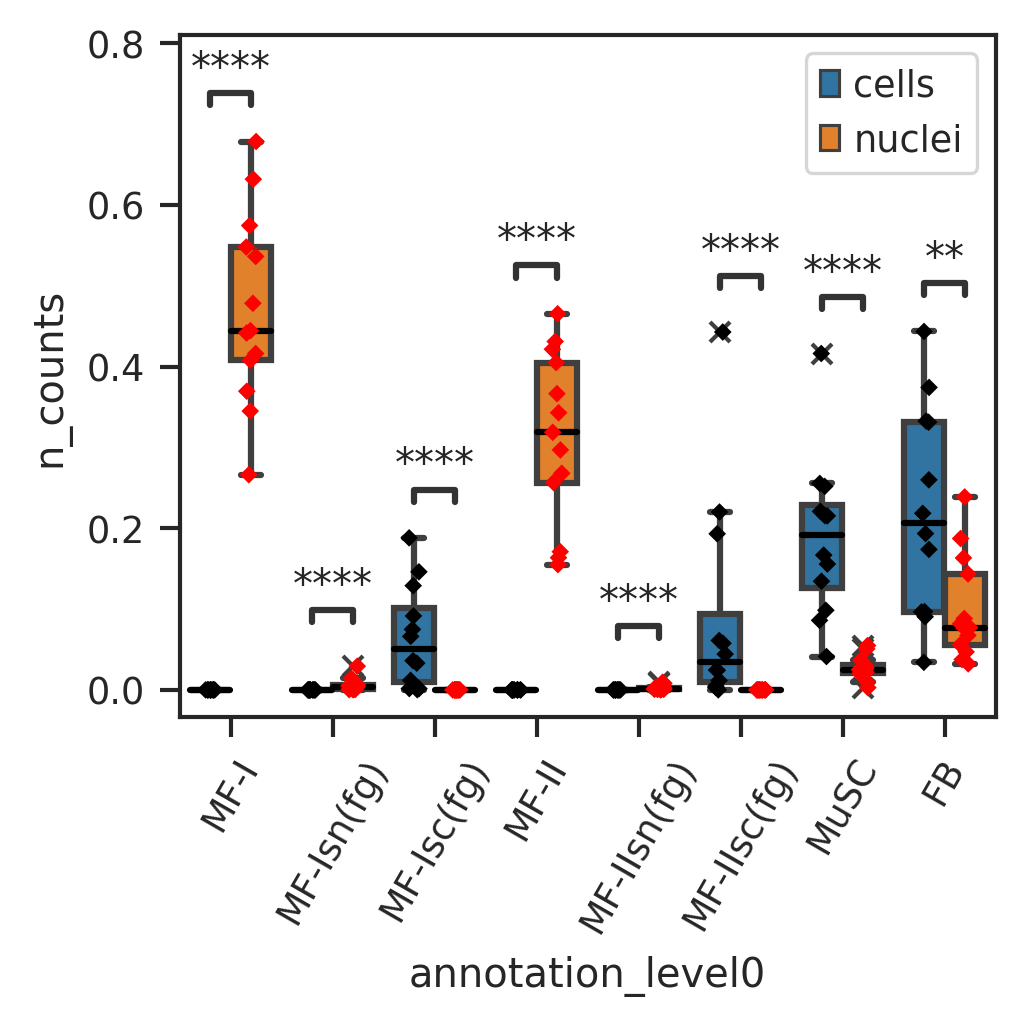

In [26]:
c2n_major = calcul_plot_prop_box2(adata_cells2nuclei_v1, 'annotation_level0', sample_anno="SampleID", donor_anno='Donor-batch-10X',
                          age_group="batch", filt_samples=True, subset_rm=[], subset_sel=ctypes_major, pairs=[],
                          plot_save='Cell2nuc_ctype_abundance_comp_major.pdf', save_dir=f'{figures}', fig_x = 3.5, fig_y = 3.5)

In [27]:
c2n_major['df'].to_csv(f'{source_files}Extended_Data_Fig1e_ratios_SourceFile.csv')
c2n_major['test_res'].to_csv(f'{source_files}Extended_Data_Fig1e_tests_SourceFile.csv')

In [58]:
c2n_major['test_res']

,test_description,test_short_name,stat_str,stat_value,pvalue,_corrected_significance,_correction_method,alpha,group1,group2
0,Mann-Whitney-Wilcoxon test two-sided,M.W.W.,U_stat,0.0,0.000008,True,Benjamini-Hochberg,0.05,"(MF-Isn(fg), cells)","(MF-Isn(fg), nuclei)"
1,Mann-Whitney-Wilcoxon test two-sided,M.W.W.,U_stat,0.0,0.000008,True,Benjamini-Hochberg,0.05,"(MF-I, cells)","(MF-I, nuclei)"
2,Mann-Whitney-Wilcoxon test two-sided,M.W.W.,U_stat,156.0,0.000005,True,Benjamini-Hochberg,0.05,"(MF-Isc(fg), cells)","(MF-Isc(fg), nuclei)"
3,Mann-Whitney-Wilcoxon test two-sided,M.W.W.,U_stat,0.0,0.000008,True,Benjamini-Hochberg,0.05,"(MF-II, cells)","(MF-II, nuclei)"
4,Mann-Whitney-Wilcoxon test two-sided,M.W.W.,U_stat,6.0,0.000027,True,Benjamini-Hochberg,0.05,"(MF-IIsn(fg), cells)","(MF-IIsn(fg), nuclei)"
5,Mann-Whitney-Wilcoxon test two-sided,M.W.W.,U_stat,149.5,0.000021,True,Benjamini-Hochberg,0.05,"(MF-IIsc(fg), cells)","(MF-IIsc(fg), nuclei)"
6,Mann-Whitney-Wilcoxon test two-sided,M.W.W.,U_stat,154.0,0.000040,True,Benjamini-Hochberg,0.05,"(MuSC, cells)","(MuSC, nuclei)"
7,Mann-Whitney-Wilcoxon test two-sided,M.W.W.,U_stat,128.0,0.007093,True,Benjamini-Hochberg,0.05,"(FB, cells)","(FB, nuclei)"


/nfs/team205/vk8/miniconda/envs/scvi-env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SMC_cells vs. SMC_nuclei: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.484e-05 U_stat=1.560e+02
NK-cell_cells vs. NK-cell_nuclei: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.535e-05 U_stat=1.510e+02
T-cell_cells vs. T-cell_nuclei: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.566e-04 U_stat=1.480e+02
Monocyte_cells vs. Monocyte_nuclei: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.391e-05 U_stat=1.520e+02
Macrophage_cells vs. Macrophage_nuclei: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.776e-03 U_stat=1.260e+02
ArtEC_cells vs. ArtEC_nuclei: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.014e-05 U_

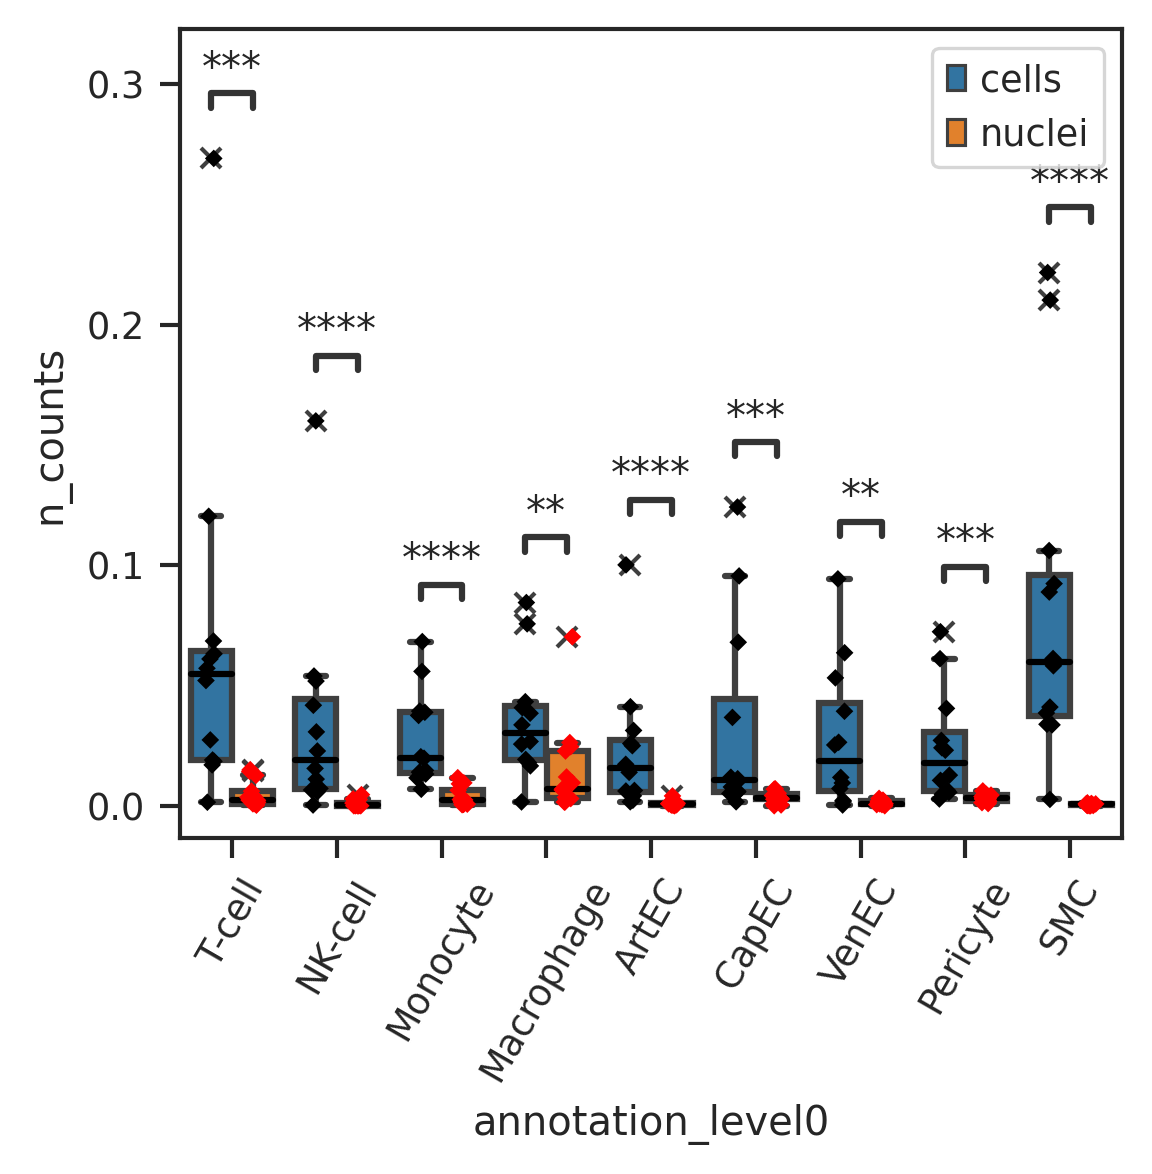

In [28]:
c2n_int = calcul_plot_prop_box2(adata_cells2nuclei_v1, 'annotation_level0', sample_anno="SampleID", donor_anno='Donor-batch-10X',
                          age_group="batch", filt_samples=True, subset_rm=[], subset_sel=ctypes_int, pairs=[],
                          plot_save='Cell2nuc_ctype_abundance_comp_int.pdf', save_dir=f'{figures}', fig_x = 4, fig_y = 4)

In [29]:
c2n_int['df'].to_csv(f'{source_files}Extended_Data_Fig1f_ratios_SourceFile.csv')
c2n_int['test_res'].to_csv(f'{source_files}Extended_Data_Fig1f_tests_SourceFile.csv')

/nfs/team205/vk8/miniconda/envs/scvi-env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

cDC2_cells vs. cDC2_nuclei: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.021e-05 U_stat=1.500e+02
Neutrophil_cells vs. Neutrophil_nuclei: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.197e-03 U_stat=1.170e+02
Mast_cells vs. Mast_nuclei: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.467e-01 U_stat=1.050e+02
LymphEC_cells vs. LymphEC_nuclei: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.712e-02 U_stat=1.090e+02
cDC1_cells vs. cDC1_nuclei: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.944e-02 U_stat=1.210e+02
PnFB_cells vs. PnFB_nuclei: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.340e-01 U_stat=5.000e+

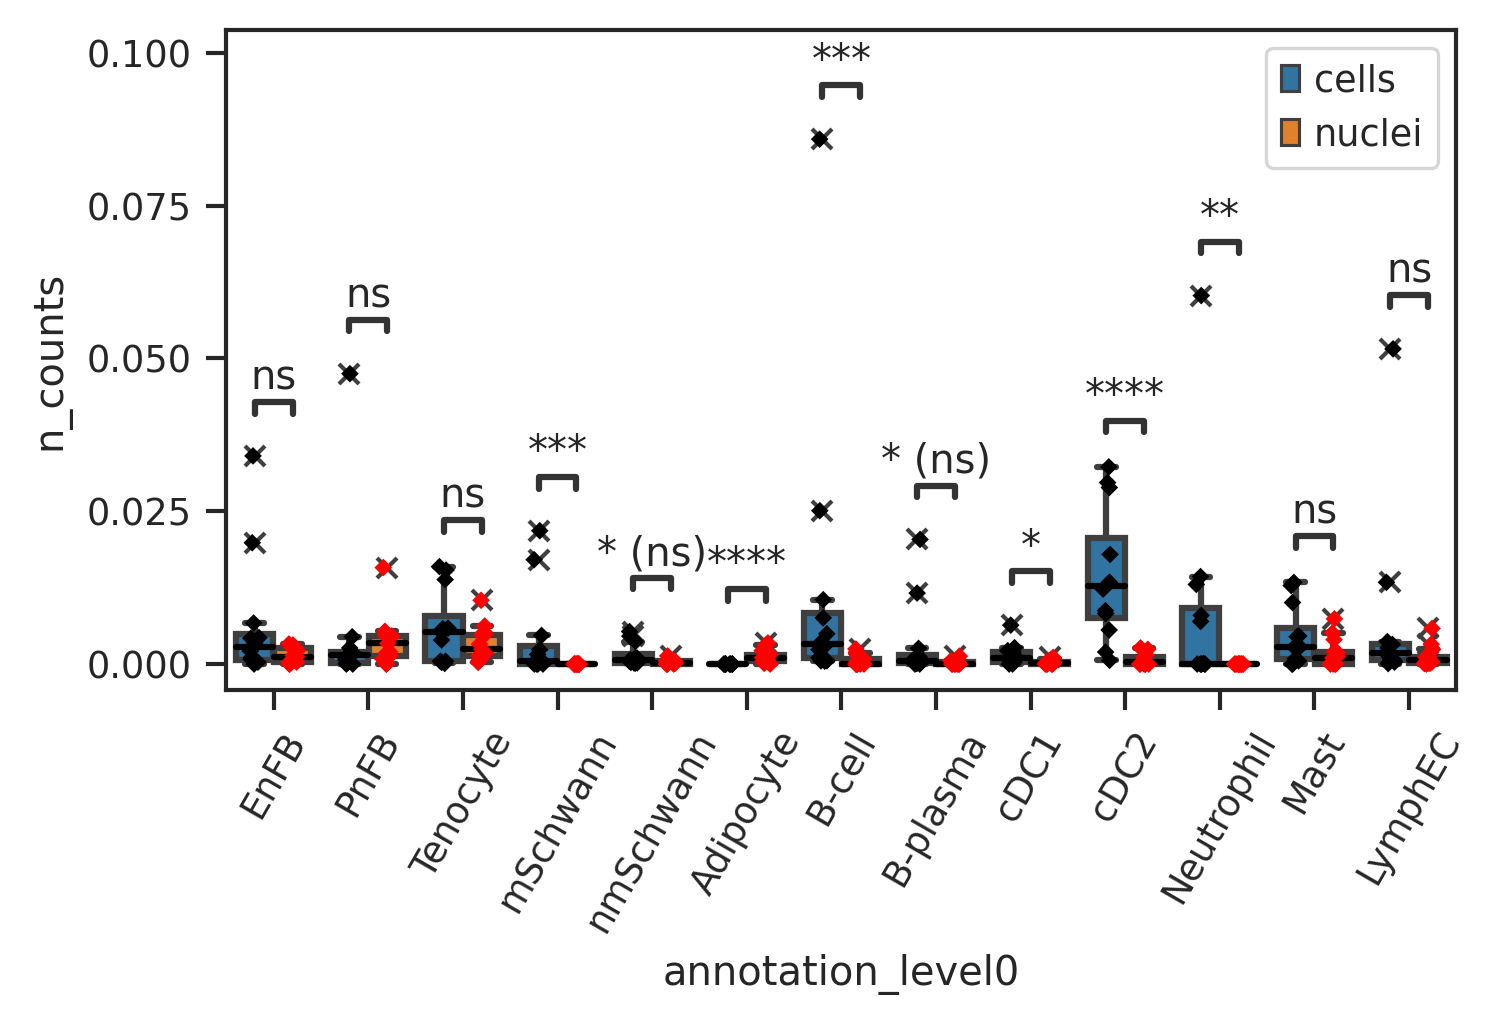

In [30]:
c2n_minor = calcul_plot_prop_box2(adata_cells2nuclei_v1, 'annotation_level0', sample_anno="SampleID", donor_anno='Donor-batch-10X',
                          age_group="batch", filt_samples=True, subset_rm=[], subset_sel=ctypes_minor, pairs=[],
                          plot_save='Cell2nuc_ctype_abundance_minor.pdf', save_dir=f'{figures}', fig_x = 5, fig_y = 3.5)

In [31]:
c2n_minor['df'].to_csv(f'{source_files}Extended_Data_Fig1g_ratios_SourceFile.csv')
c2n_minor['test_res'].to_csv(f'{source_files}Extended_Data_Fig1g_tests_SourceFile.csv')

In [33]:
sc_ctypes = ['MF-Isc(fg)', 'MF-IIsc(fg)', 
                                  "MuSC", "FB", "EnFB", "PnFB", "Tenocyte", "mSchwann", "nmSchwann", 
                                  "T-cell", "NK-cell", "B-cell", "B-plasma", 
                                  "Monocyte", "Macrophage", "cDC1", "cDC2","Neutrophil", "Mast",  
                                  "ArtEC", "CapEC", "VenEC", "LymphEC", "Pericyte", "SMC"]

In [70]:
adata_cells2nuclei_v1[adata_cells2nuclei_v1.obs['batch'] =='cells'].obs.groupby(['Donor-batch-10X', 'Age_bin'], observed = True, as_index = False).count()['Age_bin'].value_counts()

old      7
young    5
Name: Age_bin, dtype: int64

In [72]:
adata_cells2nuclei_v1[adata_cells2nuclei_v1.obs['batch'] =='cells'].obs.groupby(['DonorID', 'Age_bin'], observed = True, as_index = False).count()['Age_bin'].value_counts()

old      7
young    5
Name: Age_bin, dtype: int64

/nfs/team205/vk8/miniconda/envs/scvi-env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

T-cell_young vs. T-cell_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.490e-01 U_stat=8.000e+00
NK-cell_young vs. NK-cell_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.798e-02 (ns) U_stat=5.000e+00
B-cell_young vs. B-cell_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.020e-01 U_stat=9.000e+00
B-plasma_young vs. B-plasma_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.691e-01 U_stat=1.350e+01
Monocyte_young vs. Monocyte_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.000e+00 U_stat=1.800e+01
Macrophage_young vs. Macrophage_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.000e+00 U_s

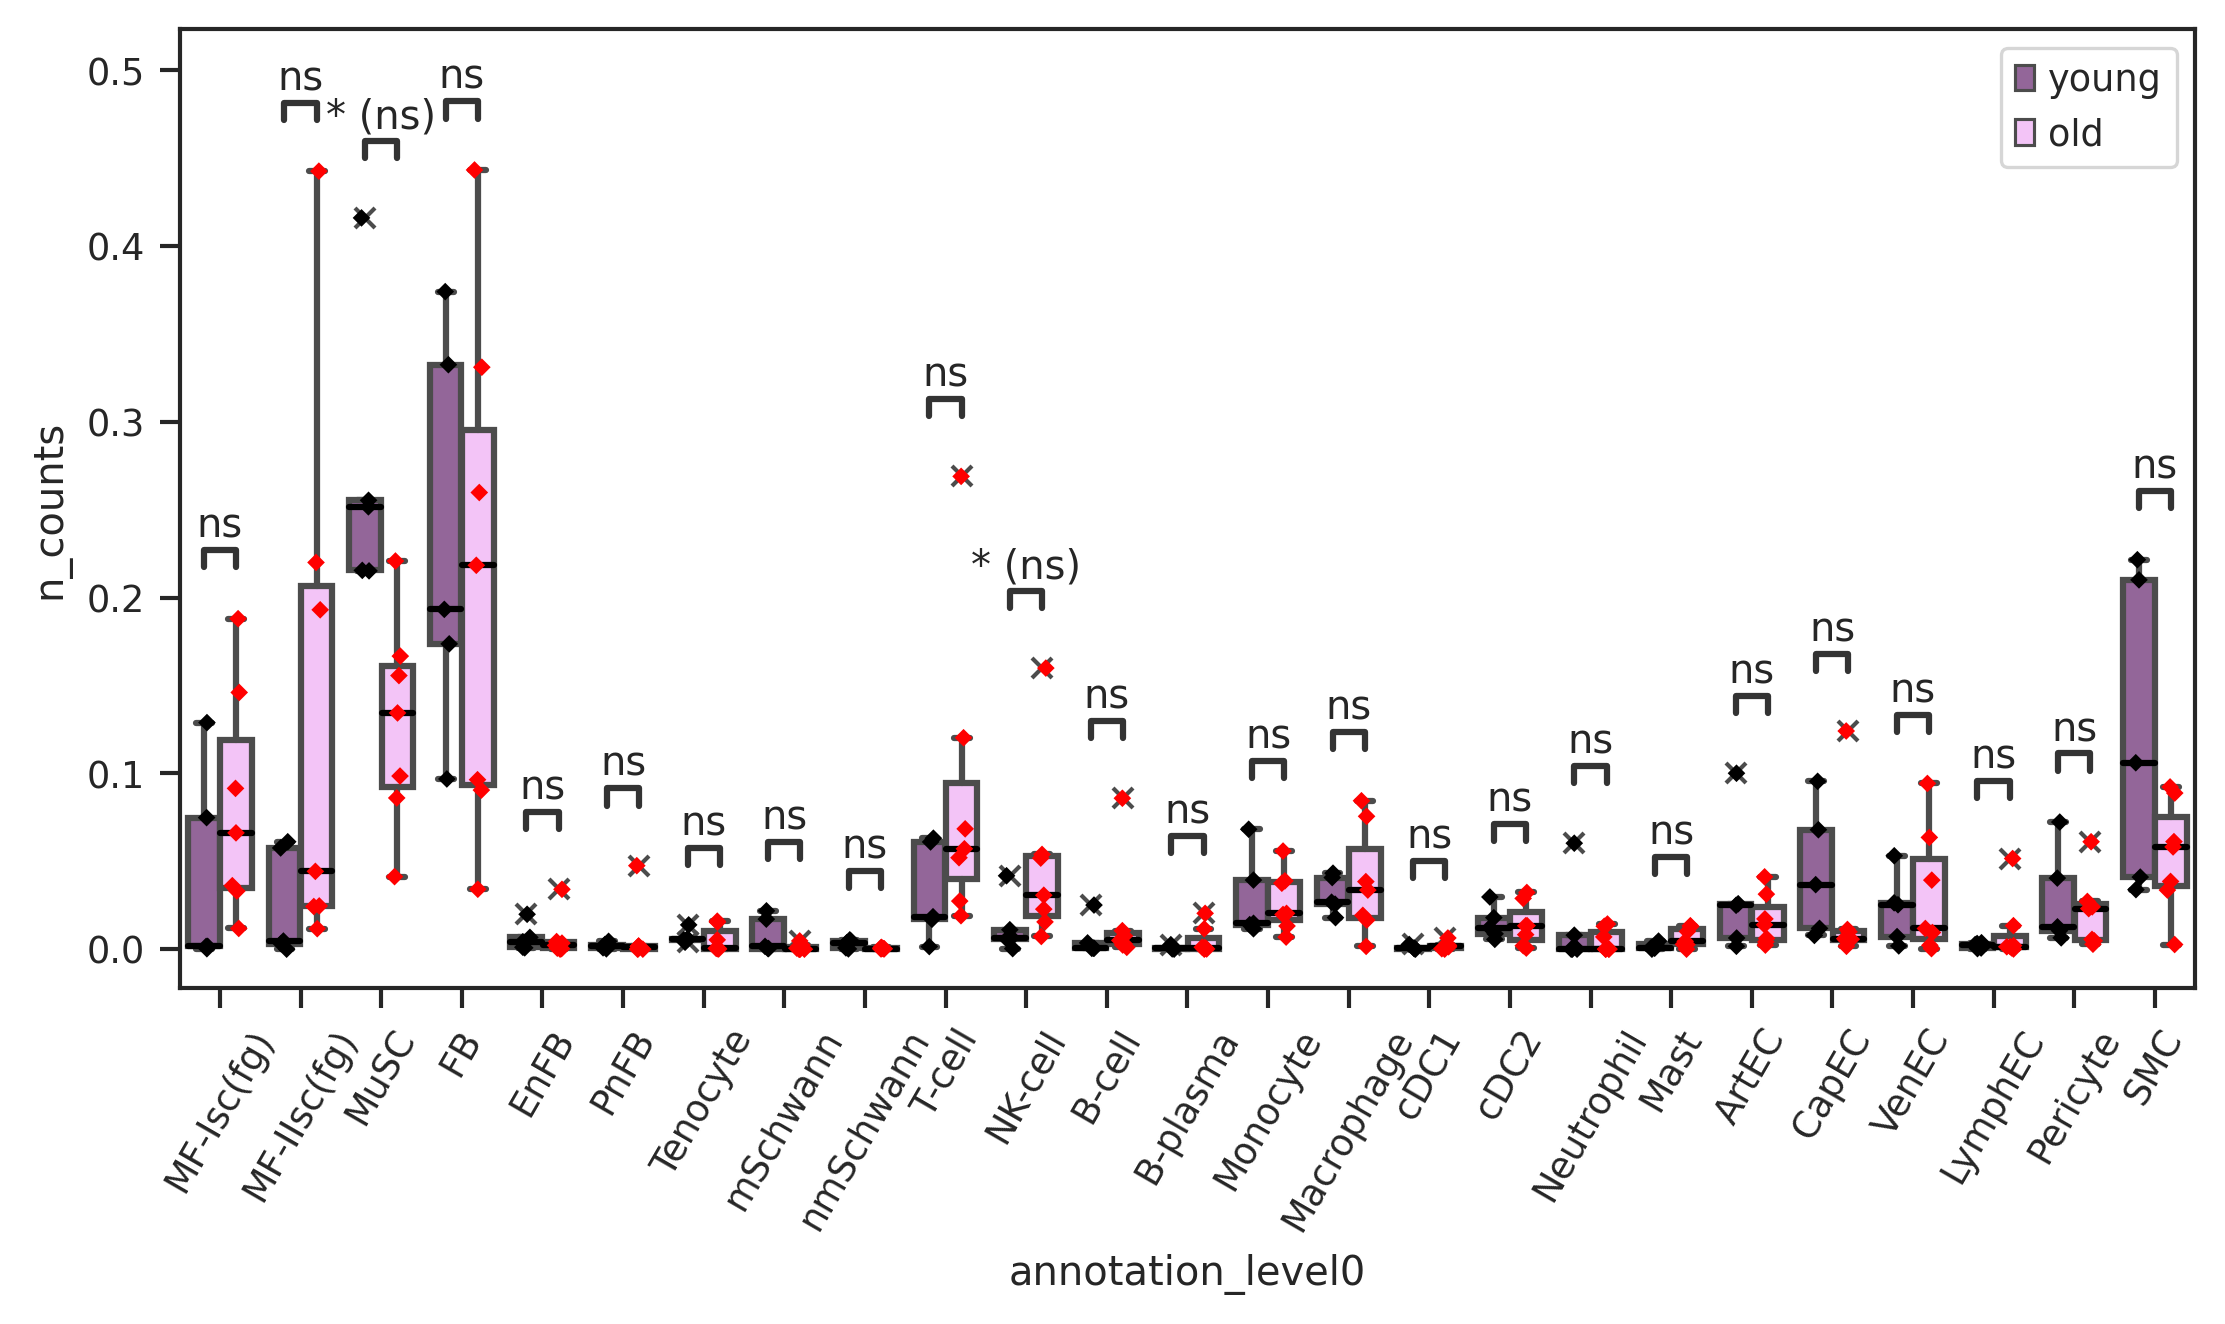

In [36]:
c2age_major = calcul_plot_prop_box2(adata_cells2nuclei_v1[adata_cells2nuclei_v1.obs['batch'] =='cells'], 'annotation_level0', 
                                    sample_anno="SampleID", donor_anno='Donor-batch-10X',
                                    age_group="Age_bin", filt_samples=True, subset_rm=[], subset_sel=sc_ctypes, pairs=[],
                          plot_save='Cell2age_ctype_abundance_comp_major.pdf', save_dir=f'{figures}', fig_x = 7.5, fig_y = 4.5,
                                   palette = ['#9a5ea1', '#fabbff'])
 #['#9a5ea1', '#fabbff'], ['#3f4ea6', '#939afa']
                                    #palette = ['#21918c', '#fde725']

c2age_major['df'].to_csv(f'{source_files}Extended_Data_Fig2a_ratios_SourceFile.csv')
c2age_major['test_res'].to_csv(f'{source_files}Extended_Data_Fig2a_tests_SourceFile.csv')

In [37]:
sn_ctypes = ['MF-I', 'MF-Isn(fg)','MF-II', 'MF-IIsn(fg)', 
                                  "MuSC", "FB", "EnFB", "PnFB", "Tenocyte", "nmSchwann", 
                                  "Adipocyte", "T-cell", "NK-cell", "B-cell", "B-plasma", 
                                  "Monocyte", "Macrophage", "cDC1", "cDC2", "Mast",  
                                  "ArtEC", "CapEC", "VenEC", "LymphEC", "Pericyte", "SMC"]

In [38]:
sn_ctypes1 = ['MF-I', 'MF-Isn(fg)','MF-II', 'MF-IIsn(fg)', 
                                  "MuSC", "FB"]

In [39]:
sn_ctypes2 = [ "EnFB", "PnFB", "Tenocyte", "nmSchwann", 
                                  "Adipocyte", "T-cell", "NK-cell", "B-cell", "B-plasma", 
                                  "Monocyte", "Macrophage", "cDC1", "cDC2", "Mast",  
                                  "ArtEC", "CapEC", "VenEC", "LymphEC", "Pericyte", "SMC"]

In [73]:
adata_cells2nuclei_v1[adata_cells2nuclei_v1.obs['batch'] =='nuclei'].obs.groupby(['Donor-batch-10X', 'Age_bin'], observed = True, as_index = False).count()['Age_bin'].value_counts()

old      8
young    7
Name: Age_bin, dtype: int64

In [74]:
adata_cells2nuclei_v1[adata_cells2nuclei_v1.obs['batch'] =='nuclei'].obs.groupby(['DonorID', 'Age_bin'], observed = True, as_index = False).count()['Age_bin'].value_counts()

old      7
young    6
Name: Age_bin, dtype: int64

/nfs/team205/vk8/miniconda/envs/scvi-env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MF-Isn(fg)_young vs. MF-Isn(fg)_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.308e-01 U_stat=2.400e+01
MF-I_young vs. MF-I_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.014e-01 U_stat=3.300e+01
MF-II_young vs. MF-II_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.452e-01 U_stat=1.500e+01
MF-IIsn(fg)_young vs. MF-IIsn(fg)_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.357e-01 U_stat=1.900e+01
MuSC_young vs. MuSC_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.128e-02 U_stat=3.500e+01
FB_young vs. FB_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.660e-01 U_stat=1.400e+01


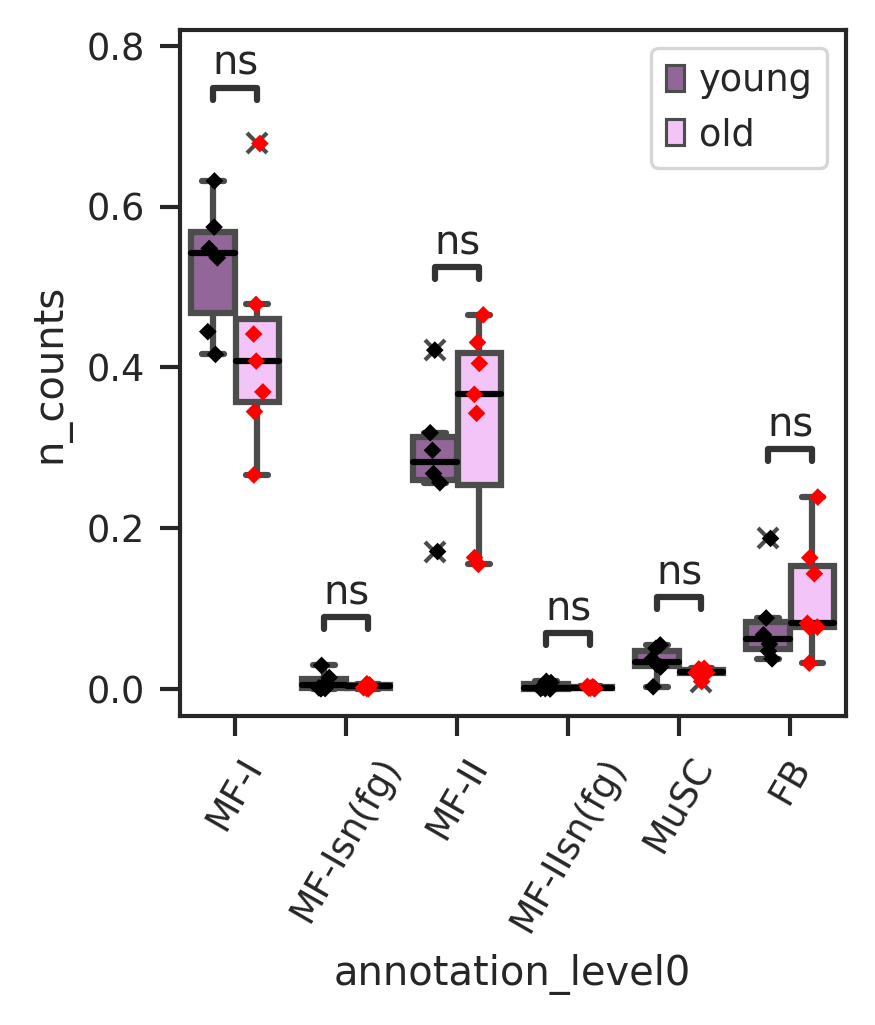

In [44]:
n2age_major = calcul_plot_prop_box2(adata_cells2nuclei_v1[adata_cells2nuclei_v1.obs['batch'] =='nuclei'], 'annotation_level0', 
                                    sample_anno="SampleID", donor_anno="Donor-batch-10X",
                          age_group="Age_bin", filt_samples=True, subset_rm=[], subset_sel=sn_ctypes1, pairs=[],
                          plot_save='Nuclei2age_ctype_abundance_comp_major.pdf', save_dir=f'{figures}', fig_x = 3, fig_y = 3.5,
                                   palette = ['#9a5ea1', '#fabbff'])
n2age_major['df'].to_csv(f'{source_files}Extended_Data_Fig2b_ratios_SourceFile.csv')
n2age_major['test_res'].to_csv(f'{source_files}Extended_Data_Fig2b_tests_SourceFile.csv')

/nfs/team205/vk8/miniconda/envs/scvi-env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Monocyte_young vs. Monocyte_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.452e-01 U_stat=2.200e+01
Macrophage_young vs. Macrophage_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.452e-01 U_stat=1.500e+01
cDC1_young vs. cDC1_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.704e-01 U_stat=1.300e+01
cDC2_young vs. cDC2_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.534e-01 U_stat=1.100e+01
Mast_young vs. Mast_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.639e-01 U_stat=1.750e+01
ArtEC_young vs. ArtEC_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.375e-01 U_stat=3.200e+01
CapEC_young

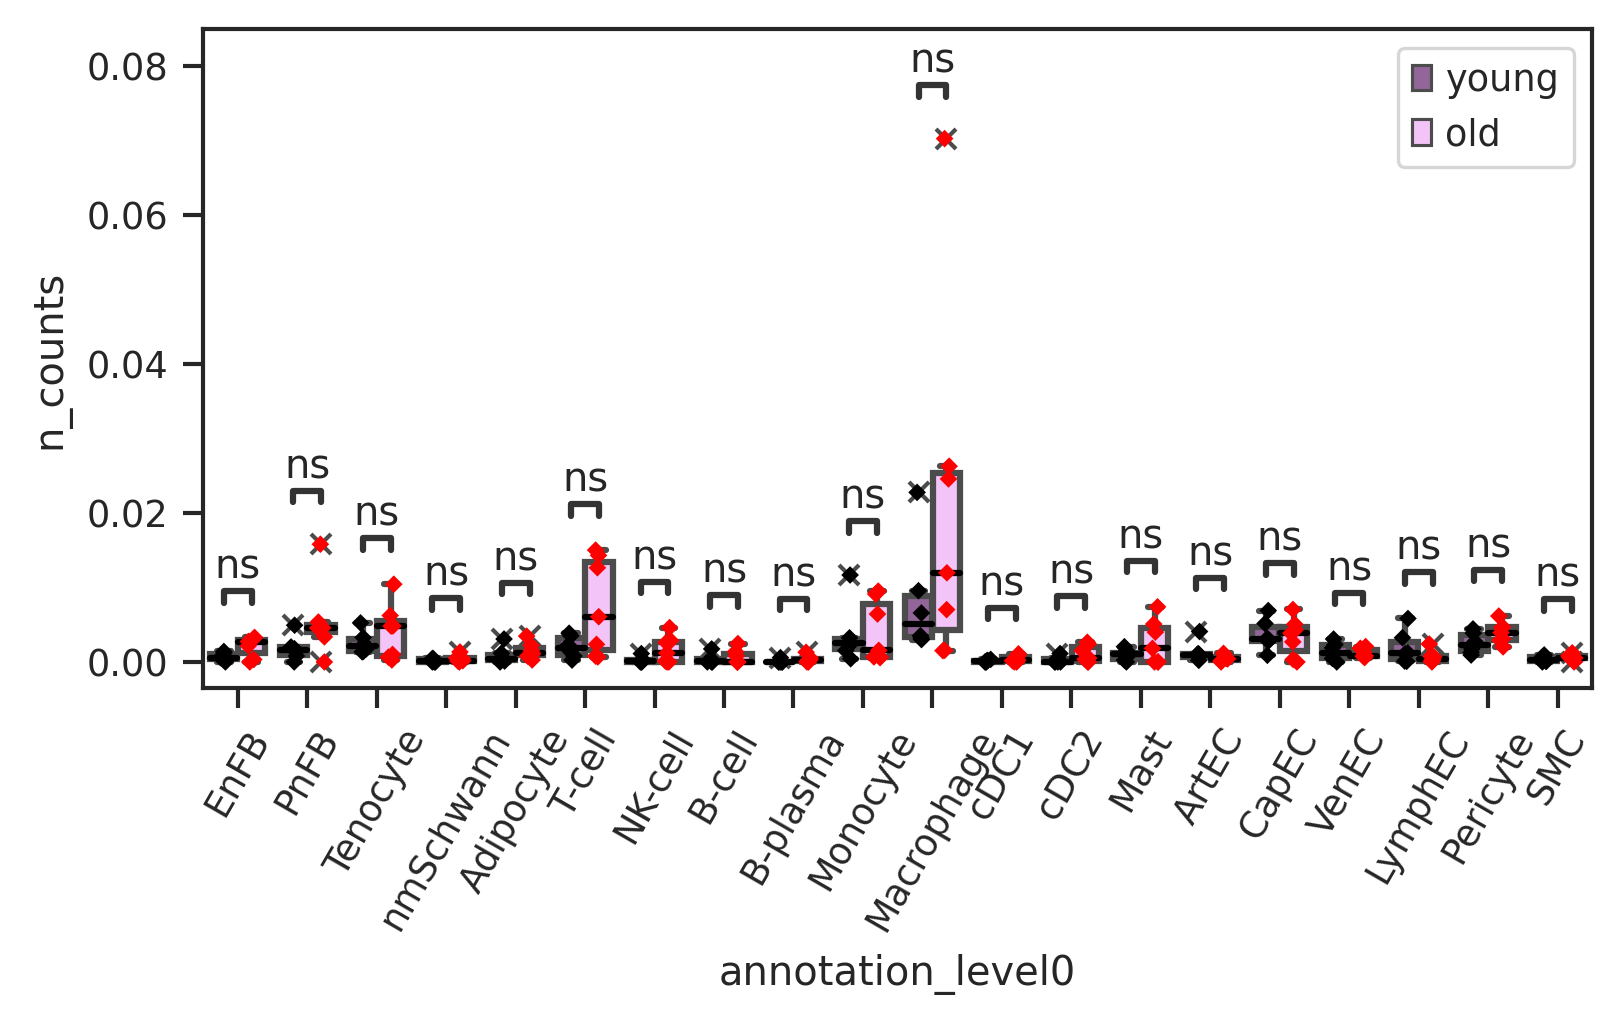

In [46]:
n2age_minor = calcul_plot_prop_box2(adata_cells2nuclei_v1[adata_cells2nuclei_v1.obs['batch'] =='nuclei'], 'annotation_level0', 
                                    sample_anno="SampleID", donor_anno="Donor-batch-10X",
                          age_group="Age_bin", filt_samples=True, subset_rm=[], subset_sel=sn_ctypes2, pairs=[],
                          plot_save='Nuclei2age_ctype_abundance_comp_minor.pdf', save_dir=f'{figures}', fig_x = 5.5, fig_y = 3.5,
                                   palette = ['#9a5ea1', '#fabbff'])

n2age_minor['df'].to_csv(f'{source_files}Extended_Data_Fig2c_ratios_SourceFile.csv')
n2age_minor['test_res'].to_csv(f'{source_files}Extended_Data_Fig2c_tests_SourceFile.csv')